In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

from skimage.util import random_noise

import matplotlib.pyplot as plt

# Load Data

In [2]:
def prepare_data_loaders(validation_size, batch_size, transform, noisy=False):

    if noisy:
        data_train = datasets.CIFAR10('/data_noisy', train=True, transform=transform, download=True)
        data_test = datasets.CIFAR10('/data_noisy', train=False, transform=transform, download=True)
    else:
        data_train = datasets.CIFAR10('/data', train=True, transform=transform, download=True)
        data_test = datasets.CIFAR10('/data', train=False, transform=transform, download=True)

    train_length = len(data_train)
    indices = list(range(train_length))
    np.random.shuffle(indices)

    split = int(np.floor(validation_size * train_length))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(data_train, batch_size=batch_size, sampler=validation_sampler)
    test_loader=DataLoader(data_test, shuffle=True, batch_size=batch_size)

    return train_loader, validation_loader, test_loader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_loader, val_loader, test_loader = prepare_data_loaders(0.2, 50, transform)

100%|██████████| 170498071/170498071 [00:13<00:00, 13002373.31it/s]


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [ ]:
class SaltAndPepper:

    def __init__(self, noise_factor):
        self.noise_factor = noise_factor

    def __call__(self, img):
        img_with_noise = torch.tensor(random_noise(img, mode="s&p", clip=True, amount=self.noise_factor))
        return img_with_noise

In [ ]:
noisy_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    SaltAndPepper(0.07)
])

In [ ]:
train_loader_noisy, val_loader_noisy, test_loader_noisy = prepare_data_loaders(0.2, 50, noisy_transform, True)

Files already downloaded and verified
Files already downloaded and verified


# visualize some images

In [ ]:
def show_some_images(loader):

    classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
         'ship', 'truck']

    dataiter = iter(loader)
    data = next(dataiter)
    imgs, labels = data

    fig=plt.figure(1,figsize=(10,5))

    for idx in range(9):
        ax = fig.add_subplot(3,3,idx+1,xticks=[],yticks=[])
        imgs[idx]=imgs[idx]*0.5+0.5
        plt.imshow(np.transpose(imgs[idx],(1,2,0)))
        ax.set_title(classes[labels[idx]])

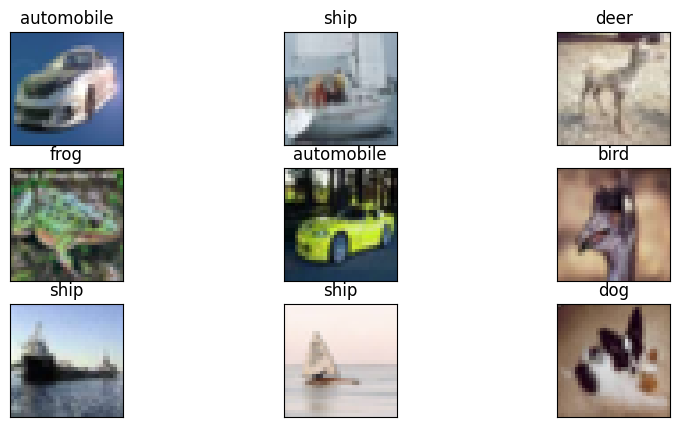

In [ ]:
show_some_images(train_loader)

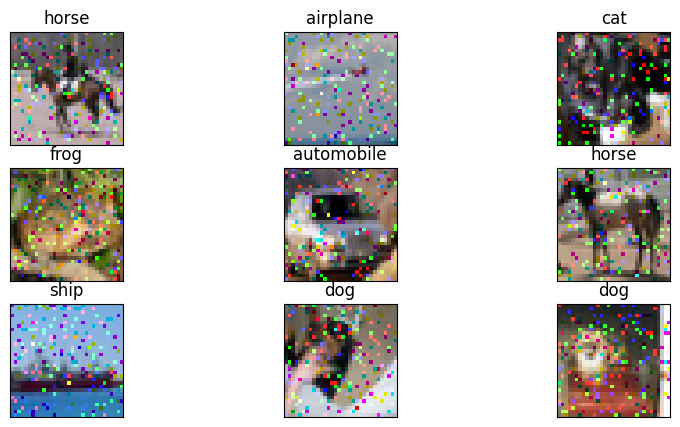

In [ ]:
show_some_images(train_loader_noisy)


# Define U-Net


In [ ]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        self.down_conv1 = self._double_conv(in_channels, 64)
        self.down_conv2 = self._double_conv(64, 128)
        self.down_conv3 = self._double_conv(128, 256)
        self.down_conv4 = self._double_conv(256, 512)
        self.down_conv5 = self._double_conv(512, 1024)

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2)

        self.up_trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = self._double_conv(1024, 512)
        self.up_trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = self._double_conv(512, 256)
        self.up_trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = self._double_conv(256, 128)
        self.up_trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = self._double_conv(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)


    def _double_conv(self, input_channel, output_channel):

        conv = nn.Sequential(
        nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True))

        return conv


    def _crop_image(self, tensor, target_tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, images):

        X1 = self.down_conv1(images)
        X2 = self.max_pool_2x2(X1)
        X3 = self.down_conv2(X2)
        X4 = self.max_pool_2x2(X3)
        X5 = self.down_conv3(X4)
        X6 = self.max_pool_2x2(X5)
        X7 = self.down_conv4(X6)
        X8 = self.max_pool_2x2(X7)
        X9 = self.down_conv5(X8)

        X = self.up_trans1(X9)
        y = self._crop_image(X7, X)
        X = self.up_conv1(torch.cat([X, y], 1))

        X = self.up_trans2(X)
        y = self._crop_image(X5, X)
        X = self.up_conv2(torch.cat([X, y], 1))

        X = self.up_trans3(X)
        y = self._crop_image(X3, X)
        X = self.up_conv3(torch.cat([X, y], 1))

        X = self.up_trans4(X)
        y = self._crop_image(X1, X)
        X = self.up_conv4(torch.cat([X, y], 1))

        X = self.out(X)

        return X

# Train Process

In [ ]:
def train(data_loader, transform, net, loss_function, optimizer, device):

    samples = 0
    cumulative_loss = 0
    net.train()

    for data in data_loader:
        images, _ = data
        noisy_images = transform(images)

        images = images.to(device)
        noisy_images = noisy_images.to(device)

        # forward
        outputs = net(noisy_images)
        loss = loss_function(outputs, images)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        samples += images.shape[0]

        cumulative_loss += loss.item() * images.shape[0]


    return cumulative_loss / samples

In [ ]:
def validation_or_test(data_loader, transform, net, loss_function, device):

    samples = 0
    cumulative_loss = 0
    net.eval()

    with torch.no_grad():
        for data in data_loader:
            images, _ = data
            noisy_images = transform(images)

            images = images.to(device)
            noisy_images = noisy_images.to(device)

            samples += images.shape[0]

            outputs = net(noisy_images)
            loss = loss_function(outputs, images)
            cumulative_loss += loss.item() * images.shape[0]


    return cumulative_loss / samples

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tr = noisy_transform=transforms.Compose([ SaltAndPepper(0.07) ])
net = UNet().to(device)
optimizer = optim.Adam(net.parameters())
loss_function = nn.MSELoss()

train_losses = []
val_losses = []

epochs = 10

for epoch in range(epochs):

  train_loss = train(train_loader, tr, net, loss_function, optimizer, device)
  train_losses.append(train_loss)

  val_loss = validation_or_test(val_loader, tr, net, loss_function, device)
  val_losses.append(val_loss)

  print(f'Epoch {epoch+1}/{epochs}')
  print(f'Train Loss: {train_loss:.4f}, *** Validation Loss: {val_loss:.4f}')

Epoch 1/10
Train Loss: 0.0115, *** Validation Loss: 0.0019
Epoch 2/10
Train Loss: 0.0016, *** Validation Loss: 0.0015
Epoch 3/10
Train Loss: 0.0012, *** Validation Loss: 0.0009
Epoch 4/10
Train Loss: 0.0010, *** Validation Loss: 0.0008
Epoch 5/10
Train Loss: 0.0008, *** Validation Loss: 0.0006
Epoch 6/10
Train Loss: 0.0006, *** Validation Loss: 0.0005
Epoch 7/10
Train Loss: 0.0005, *** Validation Loss: 0.0005
Epoch 8/10
Train Loss: 0.0004, *** Validation Loss: 0.0004
Epoch 9/10
Train Loss: 0.0004, *** Validation Loss: 0.0005
Epoch 10/10
Train Loss: 0.0004, *** Validation Loss: 0.0005


In [ ]:
def plot_metric(train, val, metric):
  plt.plot(train, label='Train')
  plt.plot(val, label='Validation')
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.title(f'Train {metric} Vs Validation {metric}')
  plt.legend()

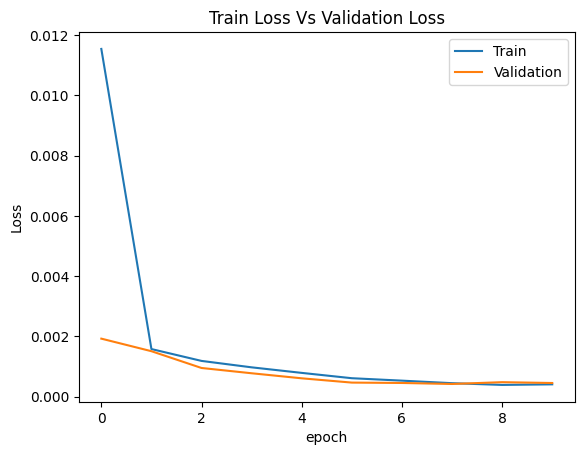

In [ ]:
plot_metric(train_losses, val_losses, 'Loss')

# Final Result

In [ ]:
test_loss = validation_or_test(test_loader, tr, net, loss_function, device)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0005


In [ ]:
noisy_dataiter = iter(test_loader_noisy)
data = next(noisy_dataiter)
noisy_imgs, noisy_labels = data

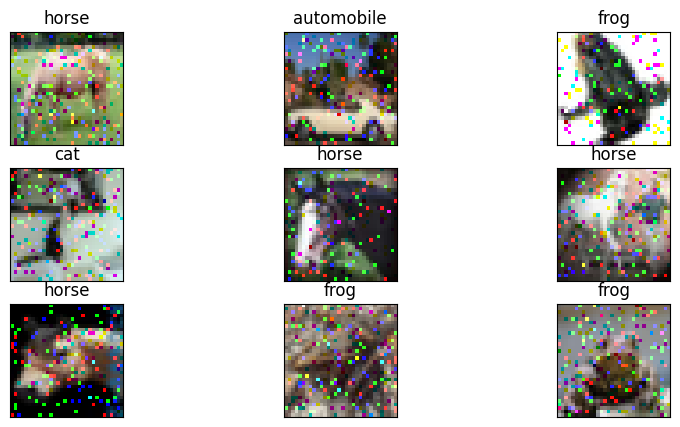

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

fig=plt.figure(1,figsize=(10,5))

for idx in range(9):
    ax = fig.add_subplot(3,3,idx+1,xticks=[],yticks=[])
    temp = noisy_imgs[idx]*0.5+0.5
    plt.imshow(np.transpose(temp,(1,2,0)))
    ax.set_title(classes[noisy_labels[idx]])

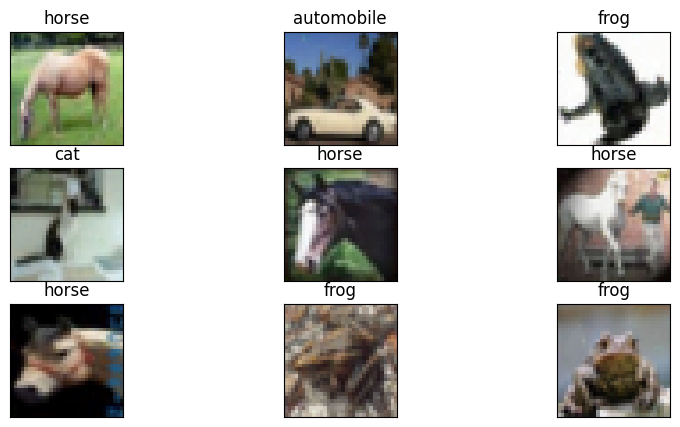

In [ ]:
net.eval()
with torch.no_grad():
    clean_images = net(noisy_imgs.to(device))

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

fig=plt.figure(1,figsize=(10,5))

for idx in range(9):
    ax = fig.add_subplot(3,3,idx+1,xticks=[],yticks=[])
    temp = clean_images[idx]*0.5+0.5
    temp = temp.cpu()
    plt.imshow(np.transpose(temp,(1,2,0)))
    ax.set_title(classes[noisy_labels[idx]])